In [1]:
from Classes.Analysis import Analysis
import numpy as np
from matplotlib import pyplot as plt
from Classes.Visualizer import Visualizer
from SALib import ProblemSpec
from scipy.integrate import solve_ivp
from SALib.analyze import sobol
from SALib.sample.sobol import sample

class System(Analysis):
    def __init__(self, graph_location):
        super().__init__(graph_location)

    def odesystem(self, t, Y, *params):
        #TODO: look at biology side, try to replicate graphs
        #TODO: explore the model(s)
        # start simple, bacteria-resource, see how the bacteria and reosurces grow/shrink, bacteria should hit carrying capacity, nutrient should reach 0, not negative, etc
        graph_object, phage_nodes, bacteria_nodes, nutrient_nodes, M, e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix = params
        graph = graph_object.graph
        def g(N, v, K):
            return (N * v) / (N + K)

        Y = self.check_cutoff(Y)
        
        N, U, I, P = self.unflatten_initial_matrix(Y, [len(nutrient_nodes), len(bacteria_nodes), (len(bacteria_nodes), M), len(phage_nodes)])
        new_N = np.zeros_like(N)
        new_U = np.zeros_like(U)
        new_I = np.zeros_like(I)
        new_P = np.zeros_like(P)
        #update N vector
        for nutrient in nutrient_nodes:
            n_index = nutrient_nodes.index(nutrient)
            e_value = e_vector[n_index] 
            sum_g = 0
            sum_u = 0
            sum_i = 0
            for bacteria in bacteria_nodes:
                b_index = bacteria_nodes.index(bacteria)
                if graph.has_edge(bacteria, nutrient):
                    v = v_matrix[b_index, n_index]
                    K = K_matrix[b_index, n_index]
                    sum_g += g(N[n_index], v, K)
                    sum_u += U[b_index]
                    sum_i += np.sum(I[b_index])
            new_N[n_index] = -(e_value * sum_g) * (sum_u + sum_i)
        
        # update U vector, i, and j are flipped relative to what is seen in update N vector for v, K, and r matrices because of how the row and columns are defined in the graph
        # dont sum U in left and right, because we are looking at an individual bacteria
        for uninfected in bacteria_nodes:
            u_index = bacteria_nodes.index(uninfected)
            g_sum = 0
            right = 0
            for nutrient in nutrient_nodes:
                n_index = nutrient_nodes.index(nutrient)
                if graph.has_edge(uninfected, nutrient):
                    g_sum += g(N[n_index], v_matrix[u_index, n_index], K_matrix[u_index, n_index])
            for phage in phage_nodes:
                p_index = phage_nodes.index(phage)
                if graph.has_edge(phage, uninfected):
                    right += r_matrix[p_index, u_index] * P[p_index]
            new_U[u_index] = g_sum * U[u_index] - right * U[u_index]

        for infected in bacteria_nodes:
            i_index = bacteria_nodes.index(infected)
            for infected_stage in range(0, M):
                if infected_stage == 0:
                    left_sum = 0
                    right_sum = 0
                    for phage in phage_nodes:
                        p_index = phage_nodes.index(phage)
                        if graph.has_edge(phage, infected):
                            left_sum += r_matrix[p_index, i_index] * P[p_index]
                            right_sum += M / tau_vector[i_index] * I[i_index, 0]
                    new_I[i_index, 0] = left_sum * U[i_index] - right_sum
                else:
                    m_tau = M / tau_vector[i_index]
                    right = I[i_index, infected_stage - 1] - I[i_index, infected_stage]
                    new_I[i_index, infected_stage] = m_tau * right
        
        for phage in phage_nodes:
            p_index = phage_nodes.index(phage)
            left_sum = 0
            right_sum = 0
            for infected in bacteria_nodes:
                i_index = bacteria_nodes.index(infected)
                if graph.has_edge(phage, infected):
                    left_sum += B_matrix[p_index, i_index] * M / tau_vector[i_index] * I[i_index, -1]
                    right_sum += r_matrix[p_index, i_index] * (U[i_index] + np.sum(I[i_index])) * P[p_index]
            new_P[p_index] = left_sum - right_sum

        flattened_y1 = self.flatten_lists_and_matrices(new_N, new_U, new_I, new_P)
        return flattened_y1

graph = System('simple_test_2.gexf')
phage_nodes = graph.get_nodes_of_type('P')
bacteria_nodes = graph.get_nodes_of_type('B')
resource_nodes = graph.get_nodes_of_type('R')
environemnt_nodes = graph.get_nodes_of_type('E')

R0 = graph.initialize_new_parameter_from_node(resource_nodes, "Initial_Concentration")
U0 = graph.initialize_new_parameter_from_node(bacteria_nodes, "Initial_Population")
I0 = graph.initialize_new_matrix(len(U0), graph.M)
P0 = graph.initialize_new_parameter_from_node(phage_nodes, "Initial_Population")

e_vector = graph.initialize_new_parameter_from_node(resource_nodes, 'e')
tau_vector = graph.initialize_new_parameter_from_node(bacteria_nodes, 'tau')
v_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'v')
K_matrix = graph.initialize_new_parameter_from_edges(bacteria_nodes, resource_nodes, 'K')
r_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'r')
B_matrix = graph.initialize_new_parameter_from_edges(phage_nodes, bacteria_nodes, 'Burst_Size')
visualizer = Visualizer(graph)
new_graphing_data = [R0, U0, I0, P0]
flattened = graph.flatten_lists_and_matrices(*new_graphing_data)
new_non_graphing_data_vectors = [e_vector, tau_vector]
new_non_graphing_data_matrices = [v_matrix, K_matrix, r_matrix, B_matrix]
# Define the problem
problem_spec = ProblemSpec({
    'num_vars': 6,
    'names': ["R", "U", "I1", "I2", "I3", "I4", "P", 'e', 'tau', 'v', 'K', 'r', 'B'],
    'bounds': [[1, 10000], [1, 10000], [0, 50], [0, 50], [0, 50], [0, 50], [1, 10000], [0.01, 2], [0.01, 2], [0.01, 2], [0.01, 20], [0.01, 2], [10, 200]]
})

In [2]:
problem_spec = ProblemSpec({
    'num_vars': 9,
    'names': ["R", "U", "P", 'e', 'tau', 'v', 'K', 'r', 'B'],
    'bounds': [[1, 10000], [1, 10000], [1, 10000], [0.01, 2], [0.01, 2], [0.01, 2], [0.01, 20], [0.01, 2], [10, 200]]
})

param_samples = sample(problem_spec, 2**10)

t_start = 0
t_end = 10
t_steps = 100
t_eval = np.linspace(t_start, t_end, t_steps)

Y_final_R = np.zeros(len(param_samples))
Y_avg_R = np.zeros(len(param_samples))
Y_var_R = np.zeros(len(param_samples))
Y_time_R = np.zeros((len(param_samples), len(t_eval))) 

Y_final_U = np.zeros(len(param_samples))
Y_avg_U = np.zeros(len(param_samples))
Y_var_U = np.zeros(len(param_samples))
Y_time_U = np.zeros((len(param_samples), len(t_eval))) 

Y_final_I = np.zeros(len(param_samples))
Y_avg_I = np.zeros(len(param_samples))
Y_var_I = np.zeros(len(param_samples))
Y_time_I = np.zeros((len(param_samples), len(t_eval))) 

Y_final_P = np.zeros(len(param_samples))
Y_avg_P = np.zeros(len(param_samples))
Y_var_P = np.zeros(len(param_samples))
Y_time_P = np.zeros((len(param_samples), len(t_eval))) 

# Run simulations
for i, params in enumerate(param_samples):
    flattened[0] = params[0]
    flattened[1] = params[1]
    flattened[6] = params[2]
    e_vector[0] = params[3]
    tau_vector[0] = params[4]
    v_matrix[0, 0] = params[5]
    K_matrix[0, 0] = params[6]
    r_matrix[0, 0] = params[7]
    B_matrix[0, 0] = params[8]
    list_to_pass = [graph, phage_nodes, bacteria_nodes, resource_nodes, int(graph.M), e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix]
    sol = solve_ivp(graph.odesystem, (t_start, t_end), flattened, args=tuple(list_to_pass), t_eval=t_eval)
    overall_y = graph.unflatten_initial_matrix(sol.y, [len(resource_nodes), len(bacteria_nodes), int(graph.M), len(phage_nodes)])
    overall_y[2] = visualizer.sum_up_columns(overall_y[2], int(graph.M))

    resource_pop = overall_y[0][0] 
    uninfected_pop = overall_y[1][0] 
    infected_pop = overall_y[2][0] 
    phage_pop = overall_y[3][0] 

    Y_final_R[i] = resource_pop[-1] 
    Y_avg_R[i] = np.mean(resource_pop) 
    Y_var_R[i] = np.var(resource_pop) 
    Y_time_R[i, :] = resource_pop 

    Y_final_U[i] = uninfected_pop[-1] 
    Y_avg_U[i] = np.mean(uninfected_pop) 
    Y_var_U[i] = np.var(uninfected_pop) 
    Y_time_U[i, :] = uninfected_pop 

    Y_final_I[i] = infected_pop[-1] 
    Y_avg_I[i] = np.mean(infected_pop) 
    Y_var_I[i] = np.var(infected_pop) 
    Y_time_I[i, :] = infected_pop 

    Y_final_P[i] = phage_pop[-1] 
    Y_avg_P[i] = np.mean(phage_pop) 
    Y_var_P[i] = np.var(phage_pop) 
    Y_time_P[i, :] = phage_pop 

Si_time_R = [sobol.analyze(problem_spec, Y_time_R[:, j]) for j in range(len(t_eval))]
Si_time_U = [sobol.analyze(problem_spec, Y_time_U[:, j]) for j in range(len(t_eval))]
Si_time_I = [sobol.analyze(problem_spec, Y_time_I[:, j]) for j in range(len(t_eval))]
Si_time_P = [sobol.analyze(problem_spec, Y_time_P[:, j]) for j in range(len(t_eval))]

np.save('Si_time_R.npy', Si_time_R)
np.save('Si_time_U.npy', Si_time_U)
np.save('Si_time_I.npy', Si_time_I)
np.save('Si_time_P.npy', Si_time_P)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/analyze/sobol.py:216: UserWarning:

Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/analyze/sobol.py:229: UserWarning:

Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/SALib/analyze/sobol.py:239: UserWarning:

Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.

/Library/Frameworks/Python.framework

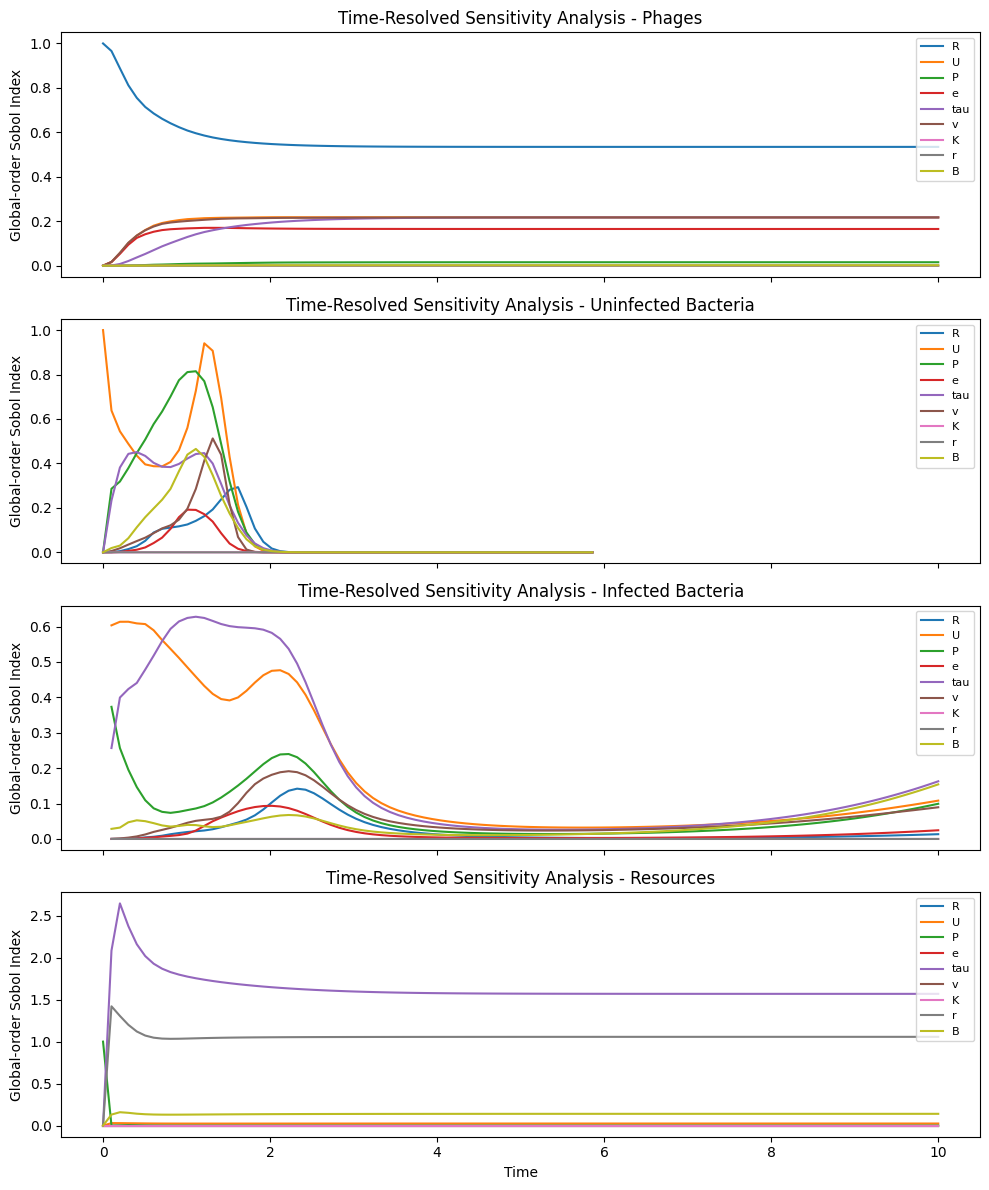

In [3]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

variables = ['Resources', 'Uninfected Bacteria', 'Infected Bacteria', 'Phages']
Si_time_vars = [Si_time_R, Si_time_U, Si_time_I, Si_time_P]
for idx, ax in enumerate(axs):
    for i, name in enumerate(problem_spec['names']):
        y_data = np.array([Si_time_vars[idx][j]['ST'][i] for j in range(len(t_eval))])
        ci = np.array([Si_time_vars[idx][j]['ST_conf'][i] for j in range(len(t_eval))])
        ax.plot(t_eval, y_data, label=name)
        ax.fill_between(t_eval, (y_data-ci), (y_data+ci), color='b', alpha=.1)
    
    ax.set_ylabel("Global-order Sobol Index")
    ax.set_title(f"Time-Resolved Sensitivity Analysis - {variables[idx]}")
    ax.legend(loc="upper right", fontsize=8)

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

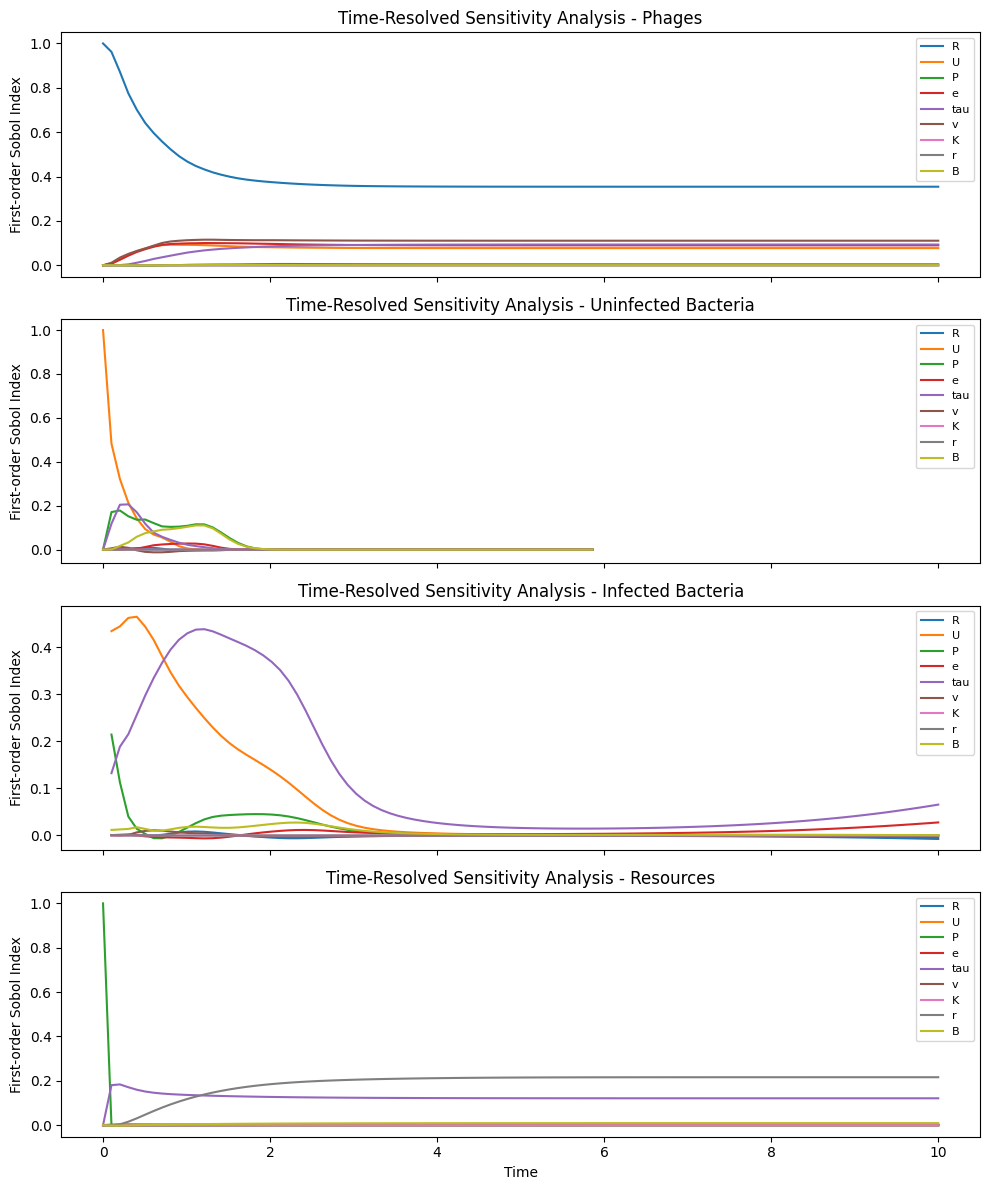

In [4]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

for idx, ax in enumerate(axs):
    for i, name in enumerate(problem_spec['names']):
        y_data = np.array([Si_time_vars[idx][j]['S1'][i] for j in range(len(t_eval))])
        ci = np.array([Si_time_vars[idx][j]['S1_conf'][i] for j in range(len(t_eval))])
        ax.plot(t_eval, y_data, label=name)
        ax.fill_between(t_eval, (y_data-ci), (y_data+ci), color='b', alpha=.1)
    
    ax.set_ylabel("First-order Sobol Index")
    ax.set_title(f"Time-Resolved Sensitivity Analysis - {variables[idx]}")
    ax.legend(loc="upper right", fontsize=8)

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()